In [1]:
# 1. 导入必要的库
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

# 设置绘图风格，让图表更好看
sns.set(style="whitegrid")
# 解决中文显示问题（如果你有中文字段）
plt.rcParams['font.sans-serif'] = ['SimHei'] 
plt.rcParams['axes.unicode_minus'] = False

# 2. 加载数据
# encoding='windows-1252' 是这种数据集常见的编码，如果报错改成 'utf-8'
try:
    df = pd.read_csv('SampleSuperstore.csv', encoding='windows-1252')
except:
    df = pd.read_csv('SampleSuperstore.csv', encoding='utf-8')

# 3. 数据预览
print("数据形状:", df.shape)
print("前5行数据:")
display(df.head())

# 4. 数据清洗 (对应简历的“清洗”)
# 检查缺失值
print("\n缺失值统计:\n", df.isnull().sum())

# 转换日期格式 (关键：为了后续画趋势图)
# 注意：SampleSuperstore.csv 中似乎没有 'Order Date' 列，跳过此步骤
try:
    if 'Order Date' in df.columns:
        df['Order Date'] = pd.to_datetime(df['Order Date'])
        # 提取月份，方便后续按月分析
        df['YearMonth'] = df['Order Date'].dt.to_period('M')
        print("\n数据清洗完成，日期格式已转换。")
except:
    print("\n注意：数据集中未找到 'Order Date' 列，跳过日期转换。")


数据形状: (9994, 14)
前5行数据:


,Ship Mode,Segment,Country,City,State,Postal Code,Region,Category,Sub-Category,Sales,Quantity,Discount,Profit,Order Date
0,Second Class,Consumer,United States,Henderson,Kentucky,42420,South,Furniture,Bookcases,261.9600,2,0.00,41.9136,08/11/2017
1,Second Class,Consumer,United States,Henderson,Kentucky,42420,South,Furniture,Chairs,731.9400,3,0.00,219.5820,08/11/2017
2,Second Class,Corporate,United States,Los Angeles,California,90036,West,Office Supplies,Labels,14.6200,2,0.00,6.8714,12/06/2017
3,Standard Class,Consumer,United States,Fort Lauderdale,Florida,33311,South,Furniture,Tables,957.5775,5,0.45,-383.0310,11/10/2016
4,Standard Class,Consumer,United States,Fort Lauderdale,Florida,33311,South,Office Supplies,Storage,22.3680,2,0.20,2.5164,11/10/2016



缺失值统计:
 Ship Mode         0
Segment           0
Country           0
City              0
State             0
Postal Code       0
Region            0
Category          0
Sub-Category      0
Sales             0
Quantity          0
Discount          0
Profit            0
Order Date      271
dtype: int64

注意：数据集中未找到 'Order Date' 列，跳过日期转换。


地区与品类的利润透视表：


Category,Furniture,Office Supplies,Technology
Region,,,
Central,-2871.0494,8879.9799,33697.4320
East,3046.1658,41014.5791,47462.0351
South,6771.2061,19986.3928,19991.8314
West,11504.9503,52609.8490,44303.6496


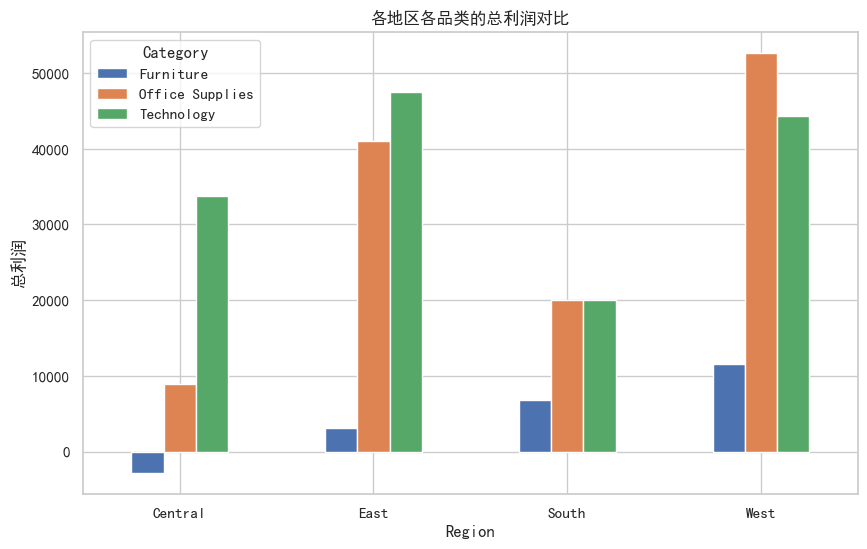

In [39]:
# 1. 地区(Region) 与 品类(Category) 的销售额与利润透视
# pivot_table 是 Excel 透视表的 Python 版
pivot_analysis = df.pivot_table(index='Region', 
                                columns='Category', 
                                values='Profit', 
                                aggfunc='sum')

print("地区与品类的利润透视表：")
display(pivot_analysis)

# 2. 可视化这个透视表
pivot_analysis.plot(kind='bar', figsize=(10, 6))
plt.title('各地区各品类的总利润对比')
plt.ylabel('总利润')
plt.xticks(rotation=0)
plt.show()

利润最差的 5 个子品类：


,Sub-Category,Sales,Profit,Discount,Profit Margin
16,Tables,206965.5320,-17725.4811,0.261285,-0.085645
4,Bookcases,114879.9963,-3472.5560,0.211140,-0.030228
15,Supplies,46673.5380,-1189.0995,0.076842,-0.025477
8,Fasteners,3024.2800,949.5182,0.082028,0.313965
11,Machines,189238.6310,3384.7569,0.306087,0.017886


C:\Users\SUO\AppData\Local\Temp\ipykernel_26728\1984469848.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Sub-Category', y='Sales', data=sub_cat_analysis, palette=colors)


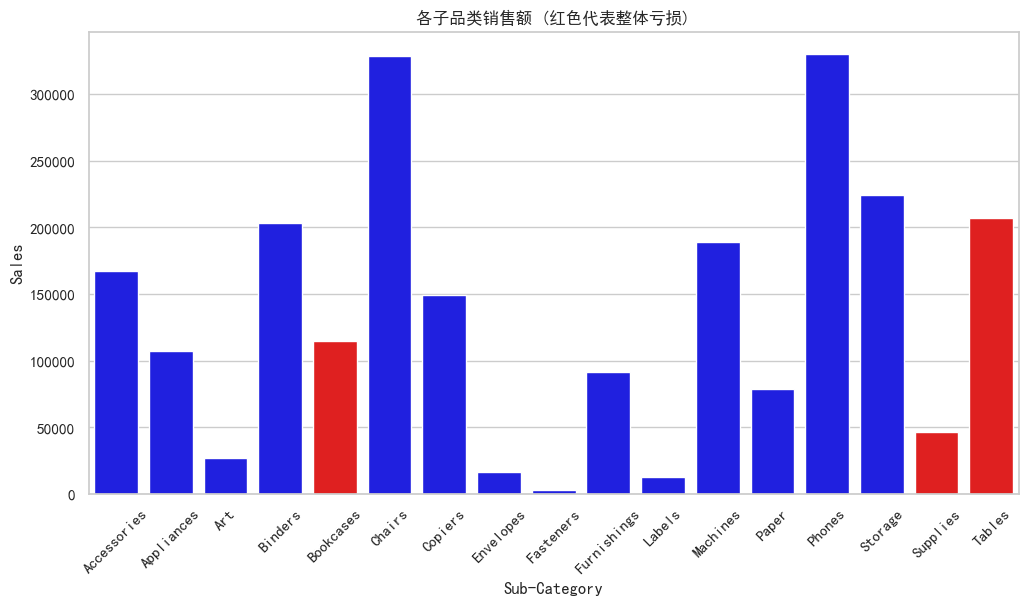

In [40]:
# 1. 按子品类 (Sub-Category) 聚合，看 销售额、利润、平均折扣
sub_cat_analysis = df.groupby('Sub-Category')[['Sales', 'Profit', 'Discount']].agg({
    'Sales': 'sum',
    'Profit': 'sum',
    'Discount': 'mean'  # 这里看平均折扣力度
}).reset_index()

# 2. 计算利润率 (Profit Margin)
sub_cat_analysis['Profit Margin'] = sub_cat_analysis['Profit'] / sub_cat_analysis['Sales']

# 3. 按利润排序，找出亏损最严重的
low_profit_items = sub_cat_analysis.sort_values('Profit', ascending=True)

print("利润最差的 5 个子品类：")
display(low_profit_items.head(5))

# 4. 可视化：销售额 vs 利润
plt.figure(figsize=(12, 6))
# 颜色映射利润：红色亏损，蓝色盈利
colors = ['red' if x < 0 else 'blue' for x in sub_cat_analysis['Profit']]
sns.barplot(x='Sub-Category', y='Sales', data=sub_cat_analysis, palette=colors)
plt.title('各子品类销售额 (红色代表整体亏损)')
plt.xticks(rotation=45)
plt.show()

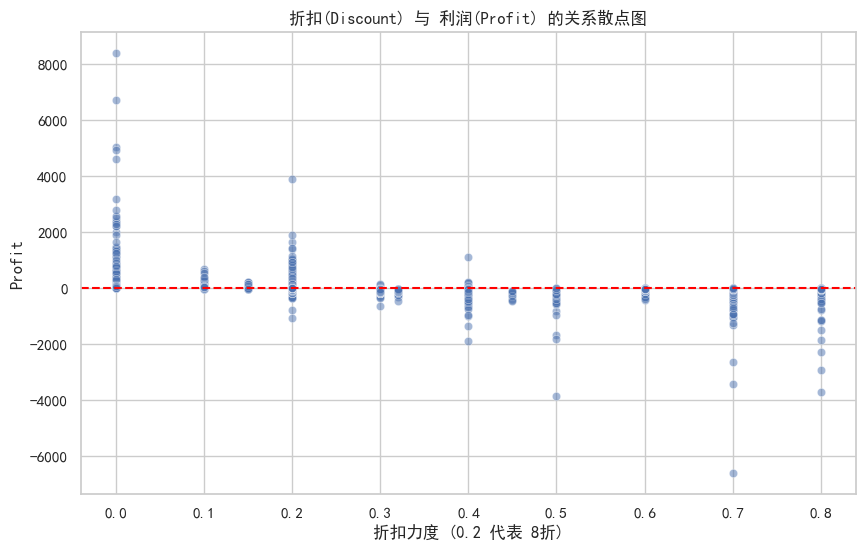

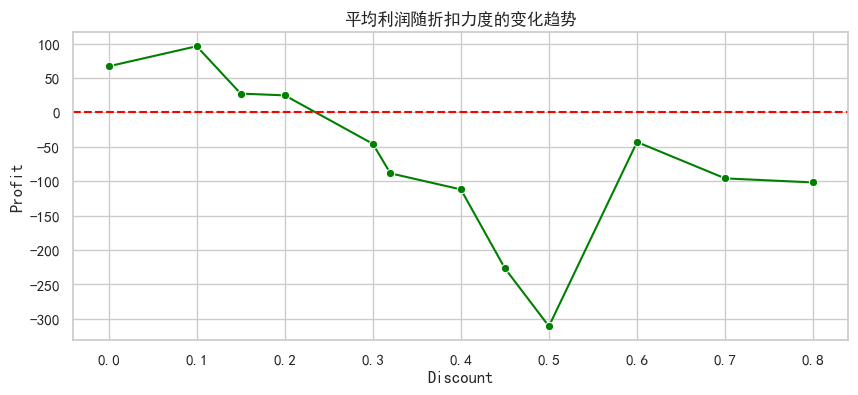

In [21]:
# 1. 散点图：每一笔订单的 折扣 vs 利润
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Discount', y='Profit', data=df, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')  # 画一条 0 利润的分界线
plt.title('折扣(Discount) 与 利润(Profit) 的关系散点图')
plt.xlabel('折扣力度 (0.2 代表 8折)')
plt.show()

# 2. 进一步量化：不同折扣区间的平均利润率
# 我们可以把折扣分组，看看打折打到多少时开始亏钱
# 找出所有唯一的折扣值
avg_profit_by_discount = df.groupby('Discount')['Profit'].mean().reset_index()

plt.figure(figsize=(10, 4))
sns.lineplot(x='Discount', y='Profit', data=avg_profit_by_discount, marker='o', color='green')
plt.axhline(0, color='red', linestyle='--')
plt.title('平均利润随折扣力度的变化趋势')
plt.show()

新生成的 YearMonth 列前5行：
  Order Date YearMonth
0 2017-11-08   2017-11
1 2017-11-08   2017-11
2 2017-06-12   2017-06
3 2016-10-11   2016-10
4 2016-10-11   2016-10


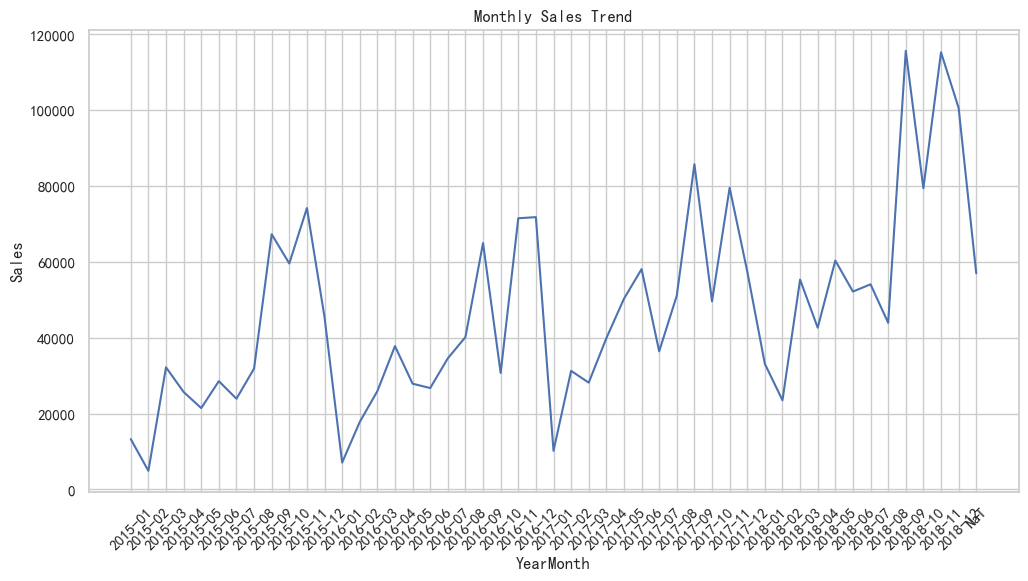

In [41]:
# --- 必须先运行这一步来创建 'YearMonth' 列 ---

# 1. 确保 'Order Date' 已经是 datetime 格式 (如果之前没转过，这里必须转)
# 注意：如果日期格式是 "日/月/年" (如 15/04/2018)，需要加 dayfirst=True
# 如果格式很乱，可以加 errors='coerce' 忽略错误，或者 format='mixed' 自动推断
if 'Order Date' in df.columns:
    df['Order Date'] = pd.to_datetime(df['Order Date'], dayfirst=True, errors='coerce')

    # 2. 从 'Order Date' 中提取出 'Year-Month' (例如 '2014-01')
    # .dt.to_period('M') 会把日期变成 '2014-01' 这种月份格式，非常适合绘图
    df['YearMonth'] = df['Order Date'].dt.to_period('M').astype(str)

    # 打印一下看看有没有生成成功
    print("新生成的 YearMonth 列前5行：")
    print(df[['Order Date', 'YearMonth']].head())

    # --- 接下来再运行可视化的代码 ---
    # 图1：销售趋势图
    monthly_trend = df.groupby('YearMonth')['Sales'].sum().reset_index()

    plt.figure(figsize=(12, 6))
    # 注意：sns.lineplot 需要横坐标是可以排序的，字符串格式的 '2014-01' 是可以排序的
    sns.lineplot(x='YearMonth', y='Sales', data=monthly_trend)
    plt.xticks(rotation=45) # 把横坐标文字旋转一下，防止重叠
    plt.title('Monthly Sales Trend')
    plt.show()
else:
    print("数据集中缺少 'Order Date' 列，无法绘制月度销售趋势图。")


In [2]:
# 模拟调整策略：如果我们将所有亏损订单的折扣强制限制在 20% (0.2) 以内，能挽回多少损失？

# 1. 找出所有“高折扣导致亏损”的订单
# 条件：折扣 > 0.2 且 利润 < 0
problematic_orders = df[(df['Discount'] > 0.2) & (df['Profit'] < 0)].copy()

print(f"发现 {len(problematic_orders)} 笔因高折扣导致亏损的订单。")
print(f"这些订单目前的总亏损额为: ${problematic_orders['Profit'].sum():.2f}")

# 2. 估算挽回的损失
# 简单估算：假设如果不打那么狠的折，这些单子哪怕不亏不赚（利润=0），或者恢复到平均利润水平。
# 这里我们保守估计：如果取消这些激进折扣，至少能帮我们把亏的钱“止损”。
potential_gain = abs(problematic_orders['Profit'].sum()) 

# 3. 计算对总利润的提升比例
total_profit = df['Profit'].sum()
improvement_percent = (potential_gain / total_profit) * 100

print(f"如果优化这部分折扣策略，预计可挽回利润: ${potential_gain:.2f}")
print(f"这将使总利润提升约: {improvement_percent:.2f}%")

发现 1348 笔因高折扣导致亏损的订单。
这些订单目前的总亏损额为: $-138515.24
如果优化这部分折扣策略，预计可挽回利润: $138515.24
这将使总利润提升约: 48.36%
